## 🔧 Setup and Imports

First, let's import the necessary libraries.

In [1]:
# Core libraries
import sys
import os
import json
import numpy as np
from pathlib import Path
from collections import Counter, defaultdict
import math

# MLX for deep learning
import mlx.core as mx
import mlx.nn as nn
import mlx.optimizers as optim

# Import our text generator
from mlx_nlp_utils import (
    TextLSTM,
    create_char_vocab,
    text_to_sequences,
    train_model,
    generate_text
)

# Define print_device_info inline to avoid import issues
def print_device_info():
    """Print current MLX device information and hardware acceleration status."""
    device = mx.default_device()
    print(f"\n🖥️  Hardware Acceleration Check:")
    print(f"   Device: {device}")
    
    if device == mx.Device(mx.gpu):
        print("   ✅ Using Apple Silicon GPU (Metal)")
        print("   ℹ️  MLX automatically optimizes for the GPU's Unified Memory.")
    else:
        print("   ⚠️  Using CPU (Slower)")

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
from wordcloud import WordCloud

# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 6)

print("✅ All libraries imported successfully!")
print("📦 MLX Text Generation is ready!")
print(f"🖥️  MLX version: {mx.__version__}")
print(f"🐍 Python version: {sys.version.split()[0]}")

# Check hardware acceleration
print_device_info()

✅ All libraries imported successfully!
📦 MLX Text Generation is ready!
🖥️  MLX version: 0.29.4
🐍 Python version: 3.13.7

🖥️  Hardware Acceleration Check:
   Device: Device(gpu, 0)
   ✅ Using Apple Silicon GPU (Metal)
   ℹ️  MLX automatically optimizes for the GPU's Unified Memory.


## 📚 Step 1: Load and Explore the Corpus

Let's load our training text and understand what we're working with.

In [2]:
# Load sample corpus
corpus_file = '../data/text_gen_samples/corpus.txt'

if not os.path.exists(corpus_file):
    print("⚠️ Sample corpus not found. Run this first:")
    print("   python ../scripts/download_datasets.py --samples")
else:
    with open(corpus_file, 'r', encoding='utf-8') as f:
        corpus = f.read()
    
    print(f"📖 Corpus loaded!")
    print(f"\n📊 Corpus Statistics:")
    print(f"   Total characters: {len(corpus):,}")
    print(f"   Total words: {len(corpus.split()):,}")
    print(f"   Total lines: {len(corpus.split(chr(10))):,}")
    print(f"\n📝 First 200 characters:")
    print(f"   {corpus[:200]}...")

📖 Corpus loaded!

📊 Corpus Statistics:
   Total characters: 366
   Total words: 52
   Total lines: 7

📝 First 200 characters:
   The quick brown fox jumps over the lazy dog.
Machine learning is a subset of artificial intelligence.
Natural language processing helps computers understand human language.
Deep learning uses neural n...


### 📊 Character Frequency Analysis

Let's see which characters appear most often in our corpus.

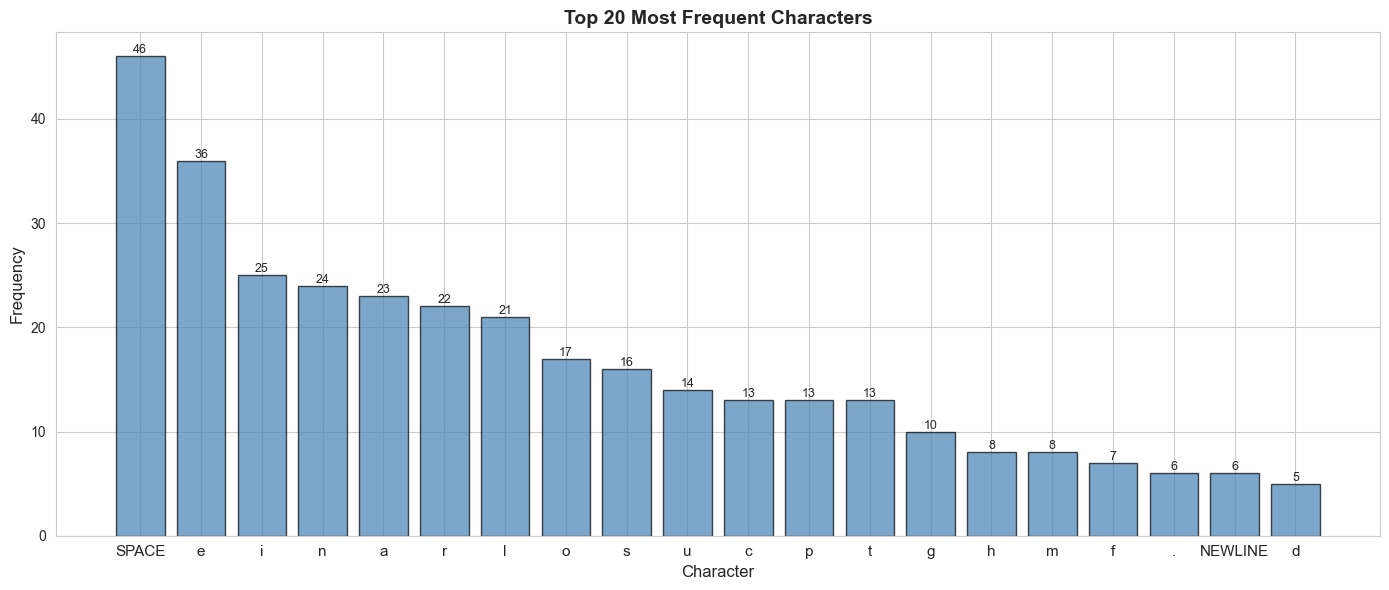


🔤 Unique characters in corpus: 38

📊 Character Distribution:
   Most common: 'SPACE' (46 occurrences)
   Least common: 9 characters appear only once


In [3]:
# Count character frequencies
char_freq = Counter(corpus)

# Get top 20 characters
top_chars = char_freq.most_common(20)
chars, counts = zip(*top_chars)

# Create bar chart
fig, ax = plt.subplots(figsize=(14, 6))

# Replace special characters for display
char_labels = []
for c in chars:
    if c == ' ':
        char_labels.append('SPACE')
    elif c == '\n':
        char_labels.append('NEWLINE')
    elif c == '\t':
        char_labels.append('TAB')
    else:
        char_labels.append(c)

bars = ax.bar(range(len(chars)), counts, color='steelblue', edgecolor='black', alpha=0.7)
ax.set_xticks(range(len(chars)))
ax.set_xticklabels(char_labels, fontsize=11)
ax.set_title('Top 20 Most Frequent Characters', fontsize=14, fontweight='bold')
ax.set_ylabel('Frequency', fontsize=12)
ax.set_xlabel('Character', fontsize=12)

# Add value labels
for bar, count in zip(bars, counts):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
           f'{count:,}',
           ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

print(f"\n🔤 Unique characters in corpus: {len(char_freq)}")
print(f"\n📊 Character Distribution:")
print(f"   Most common: '{char_labels[0]}' ({counts[0]:,} occurrences)")
print(f"   Least common: {sum(1 for c in char_freq.values() if c == 1)} characters appear only once")

### 📈 Word Cloud Visualization

See the most important words in our training corpus.

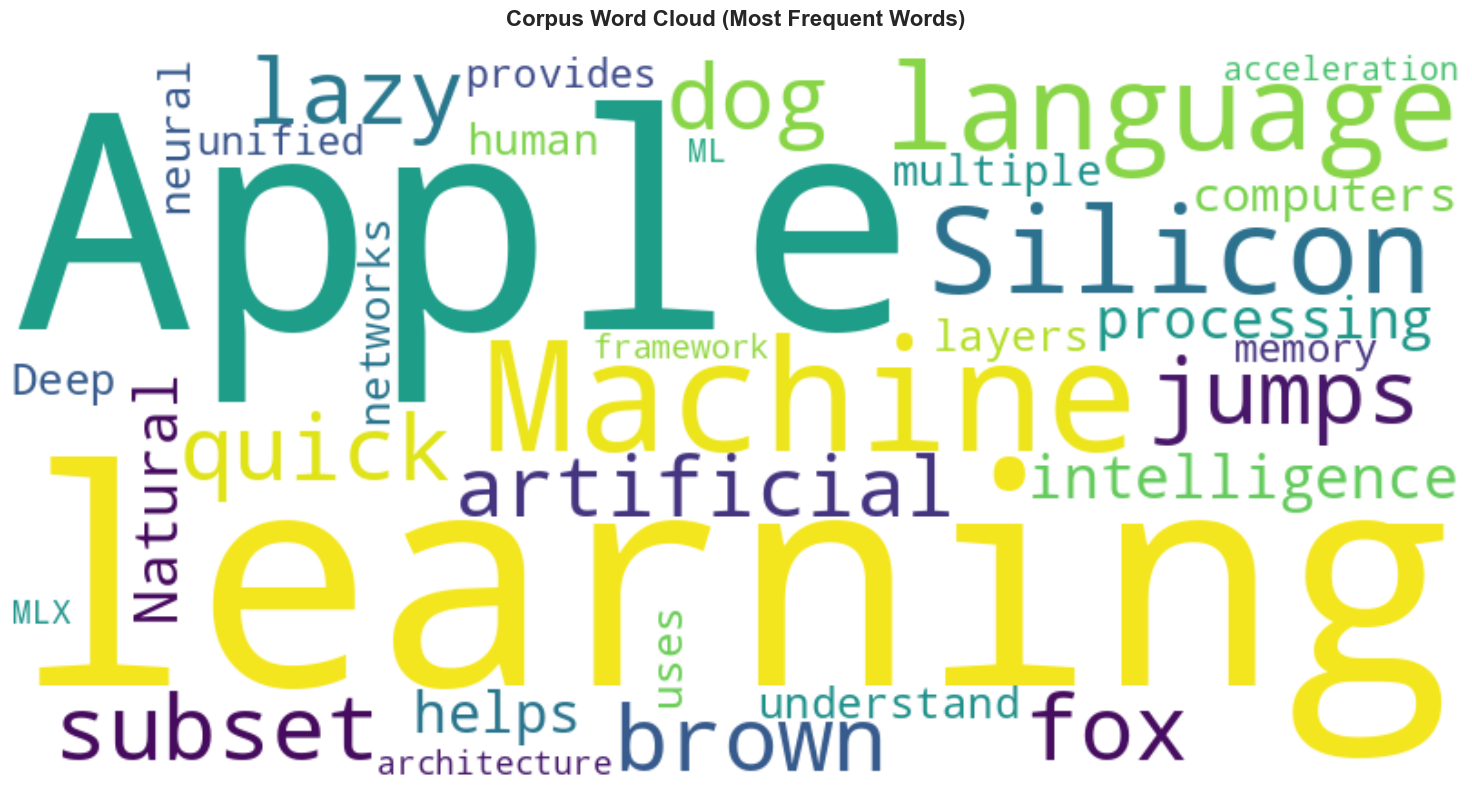

💡 Larger words appear more frequently in the corpus!


In [4]:
# Create word cloud
wordcloud = WordCloud(width=800, height=400, 
                     background_color='white',
                     colormap='viridis',
                     max_words=100).generate(corpus)

plt.figure(figsize=(16, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Corpus Word Cloud (Most Frequent Words)', fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

print("💡 Larger words appear more frequently in the corpus!")

## 🔤 Step 2: Build Character Vocabulary

Convert characters to numbers for the neural network.

In [5]:
# Create vocabulary
vocab, char_to_idx, idx_to_char = create_char_vocab(corpus)
vocab_size = len(vocab)

print(f"🔤 Vocabulary size: {vocab_size}")
print(f"\n📝 Sample vocabulary (first 20 characters):")
print(f"   {list(vocab)[:20]}")
print(f"\n🔢 Character to index mapping (first 10):")
for i, char in enumerate(list(vocab)[:10]):
    display_char = 'SPACE' if char == ' ' else 'NEWLINE' if char == '\n' else char
    print(f"   '{display_char}' → {char_to_idx[char]}")

🔤 Vocabulary size: 38

📝 Sample vocabulary (first 20 characters):
   ['j', 'T', 'q', 'c', 'e', 'w', 'k', 'l', 'i', 'p', ' ', 'X', 'o', 'M', 'g', 'u', 'a', 'L', 'h', 'b']

🔢 Character to index mapping (first 10):
   'j' → 21
   'T' → 10
   'q' → 28
   'c' → 14
   'e' → 16
   'w' → 34
   'k' → 22
   'l' → 23
   'i' → 20
   'p' → 27


### 📊 Vocabulary Growth Analysis

See how vocabulary grows as we process more text.

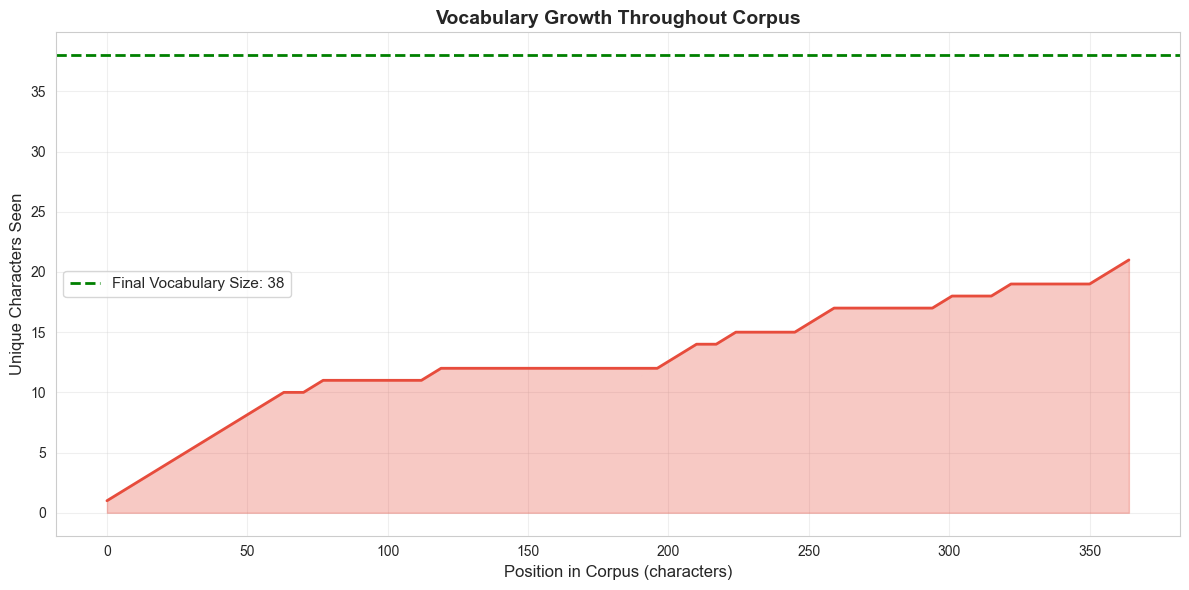

In [6]:
# Track vocabulary growth
vocab_growth = []
seen_chars = set()
sample_points = list(range(0, len(corpus), max(1, len(corpus) // 50)))

for pos in sample_points:
    seen_chars.add(corpus[pos])
    vocab_growth.append(len(seen_chars))

# Plot growth
fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(sample_points, vocab_growth, linewidth=2, color='#e74c3c')
ax.axhline(y=vocab_size, color='green', linestyle='--', linewidth=2, 
          label=f'Final Vocabulary Size: {vocab_size}')
ax.fill_between(sample_points, vocab_growth, alpha=0.3, color='#e74c3c')

ax.set_title('Vocabulary Growth Throughout Corpus', fontsize=14, fontweight='bold')
ax.set_xlabel('Position in Corpus (characters)', fontsize=12)
ax.set_ylabel('Unique Characters Seen', fontsize=12)
ax.legend(fontsize=11)
ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Calculate when we've seen 90% of vocabulary
threshold_90 = vocab_size * 0.9
for i, size in enumerate(vocab_growth):
    if size >= threshold_90:
        print(f"\n📊 Vocabulary Discovery:")
        print(f"   90% of vocabulary seen after: {sample_points[i]:,} characters")
        print(f"   That's {sample_points[i]/len(corpus)*100:.1f}% through the corpus")
        break

## 🔢 Step 3: Create Training Sequences

Split corpus into input-output pairs for training.

In [7]:
# Create sequences
seq_length = 5  # Predict next char from previous 5
X, y = text_to_sequences(corpus, char_to_idx, seq_length)

print(f"📦 Training Data Created:")
print(f"   Sequence length: {seq_length} characters")
print(f"   Number of sequences: {len(X):,}")
print(f"   X shape: {X.shape}  (sequences, seq_length)")
print(f"   y shape: {y.shape}  (sequences,)")
print(f"\n📝 Example sequence:")
print(f"   Input: {[idx_to_char[idx] for idx in X[0]]}")
print(f"   Target: '{idx_to_char[y[0]]}'")
print(f"\n   As string: '{"".join([idx_to_char[idx] for idx in X[0]])}' → '{idx_to_char[y[0]]}'")

📦 Training Data Created:
   Sequence length: 5 characters
   Number of sequences: 361
   X shape: (361, 5)  (sequences, seq_length)
   y shape: (361,)  (sequences,)

📝 Example sequence:
   Input: ['T', 'h', 'e', ' ', 'q']
   Target: 'u'

   As string: 'The q' → 'u'


## 🧠 Step 4: Model Architecture

Our text generator is the most complex model yet. It is a **Language Model**.

### 📖 Theory: Language Modeling

The goal of a language model is to predict the probability of the next token $w_t$ given the history of previous tokens $w_{1}, ..., w_{t-1}$.
$$ P(w_1, ..., w_T) = \prod_{t=1}^T P(w_t | w_{t-1}, ..., w_1) $$

### 🌡️ Math: Temperature Sampling

When generating text, we don't always want the "most likely" next character (which leads to repetitive, boring text). We sample from the probability distribution. **Temperature ($T$)** scales the logits before the Softmax function:

$$ p_i = \frac{\exp(z_i / T)}{\sum_j \exp(z_j / T)} $$

*   **$T < 1$ (Low)**: Exaggerates differences. High probabilities get higher. The model becomes conservative and confident.
*   **$T > 1$ (High)**: Flattens the distribution. Low probabilities get boosted. The model becomes random and "creative".

### 🏗️ Architecture: Character-Level LSTM

We are using a **Character-Level** model.
*   **Pros**: Small vocabulary (~100 chars vs 50k words). No "unknown word" issues. Can invent new words/names.
*   **Cons**: Sequences are longer (more time steps to model "The cat sat"). Harder to capture long-term semantic meaning compared to word-level models.

**Why so large?**
- Language modeling is harder than classification.
- Needs to capture syntax, grammar, style.
- Must remember long-range dependencies.

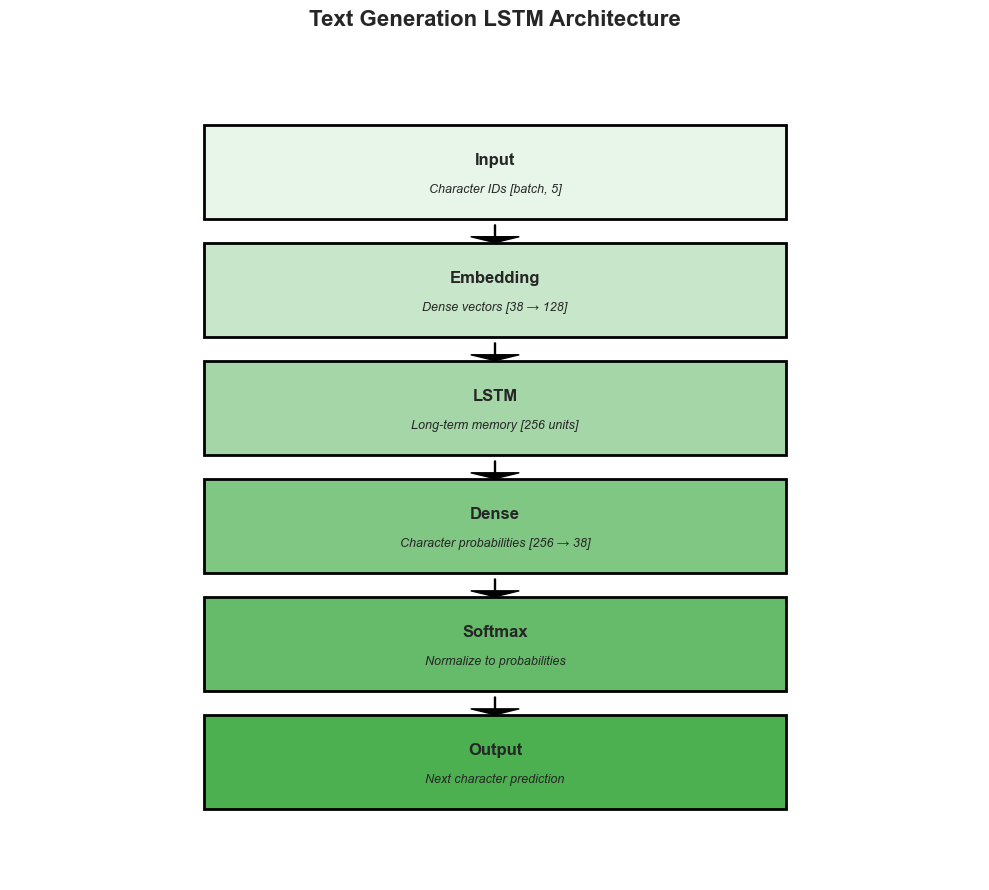


📊 Model Complexity:
   Embedding params: 4,864
   LSTM params: ~394,240
   Output params: 9,766
   Total: ~408,870 parameters

💡 This is 408.9x larger than the intent classifier!


In [8]:
# Visualize architecture
fig, ax = plt.subplots(figsize=(10, 9))

# Architecture details
layers = [
    {"name": "Input", "desc": f"Character IDs [batch, {seq_length}]", "color": "#e8f5e9"},
    {"name": "Embedding", "desc": f"Dense vectors [{vocab_size} → 128]", "color": "#c8e6c9"},
    {"name": "LSTM", "desc": "Long-term memory [256 units]", "color": "#a5d6a7"},
    {"name": "Dense", "desc": f"Character probabilities [256 → {vocab_size}]", "color": "#81c784"},
    {"name": "Softmax", "desc": "Normalize to probabilities", "color": "#66bb6a"},
    {"name": "Output", "desc": "Next character prediction", "color": "#4caf50"}
]

# Draw layers
y_pos = len(layers) - 1
for i, layer in enumerate(layers):
    # Layer box
    rect = plt.Rectangle((0.2, y_pos - 0.4), 0.6, 0.8,
                         facecolor=layer["color"], edgecolor='black', linewidth=2)
    ax.add_patch(rect)
    
    # Layer name
    ax.text(0.5, y_pos + 0.1, layer["name"],
           ha='center', va='center', fontsize=12, fontweight='bold')
    
    # Layer description
    ax.text(0.5, y_pos - 0.15, layer["desc"],
           ha='center', va='center', fontsize=9, style='italic')
    
    # Arrow to next layer
    if i < len(layers) - 1:
        ax.arrow(0.5, y_pos - 0.45, 0, -0.1,
                head_width=0.05, head_length=0.05, fc='black', ec='black')
    
    y_pos -= 1

ax.set_xlim(0, 1)
ax.set_ylim(-1, len(layers))
ax.axis('off')
ax.set_title('Text Generation LSTM Architecture', fontsize=16, fontweight='bold', pad=20)

plt.tight_layout()
plt.show()

print("\n📊 Model Complexity:")
print(f"   Embedding params: {vocab_size * 128:,}")
print(f"   LSTM params: ~{4 * 256 * (128 + 256 + 1):,}")
print(f"   Output params: {256 * vocab_size + vocab_size:,}")
total_params = vocab_size * 128 + 4 * 256 * (128 + 256 + 1) + 256 * vocab_size + vocab_size
print(f"   Total: ~{total_params:,} parameters")
print(f"\n💡 This is {total_params / 1000:.1f}x larger than the intent classifier!")

## 🏋️ Step 5: Training with Perplexity Tracking

**Perplexity** is the standard metric for evaluating language models.

### 🧮 The Math of Perplexity

Perplexity ($PP$) measures how "surprised" the model is by the data. It is defined as the exponentiated average negative log-likelihood (Cross-Entropy Loss):

$$ PP(W) = \exp\left(-\frac{1}{N} \sum_{i=1}^N \ln P(w_i | w_{<i})\right) = \exp(\text{Loss}) $$

**Intuition:**
*   If the model is perfectly confident (probability 1.0 for correct char), Loss = 0, Perplexity = $e^0 = 1$.
*   If the model is guessing randomly among $k$ options, Perplexity $\approx k$.
*   **Lower is better.** A perplexity of 20 means the model is as confused as if it were choosing uniformly from 20 possibilities.

In [9]:
# Initialize model
model = TextLSTM(vocab_size=vocab_size, embedding_dim=128, hidden_size=256)

print("🏗️ Model initialized!")
print("\n🎯 Training configuration:")
print("   Epochs: 200")
print("   Optimizer: Adam")
print("   Learning rate: 0.001")
print("   Batch size: Full batch")
print("\n⏳ Training... (this may take 2-3 minutes)")

# Train with history tracking
history = {'loss': [], 'perplexity': []}

import mlx.core as mx
import mlx.nn as nn
import mlx.optimizers as optim

def loss_fn(model, X, y):
    logits = model(mx.array(X))
    # Take only the last position's logits for prediction
    logits_last = logits[:, -1, :]
    return mx.mean(nn.losses.cross_entropy(logits_last, mx.array(y)))

optimizer = optim.Adam(learning_rate=0.001)
loss_and_grad_fn = nn.value_and_grad(model, loss_fn)

epochs = 200
for epoch in range(epochs):
    # Forward and backward pass
    loss, grads = loss_and_grad_fn(model, X, y)
    optimizer.update(model, grads)
    
    # Force evaluation (Lazy Evaluation pattern)
    # MLX builds a computation graph but doesn't run it until needed.
    # mx.eval() forces execution to update parameters in memory.
    mx.eval(model.parameters(), optimizer.state)
    
    # Calculate perplexity
    perplexity = float(mx.exp(loss))
    
    # Store history
    history['loss'].append(float(loss))
    history['perplexity'].append(perplexity)
    
    # Print progress
    if (epoch + 1) % 20 == 0:
        print(f"Epoch {epoch + 1:3d}/200 - Loss: {loss:.4f} - Perplexity: {perplexity:.2f}")

print("\n✅ Training complete!")

🏗️ Model initialized!

🎯 Training configuration:
   Epochs: 200
   Optimizer: Adam
   Learning rate: 0.001
   Batch size: Full batch

⏳ Training... (this may take 2-3 minutes)
Epoch  20/200 - Loss: 2.6065 - Perplexity: 13.55
Epoch  20/200 - Loss: 2.6065 - Perplexity: 13.55
Epoch  40/200 - Loss: 0.6400 - Perplexity: 1.90
Epoch  60/200 - Loss: 0.0561 - Perplexity: 1.06
Epoch  40/200 - Loss: 0.6400 - Perplexity: 1.90
Epoch  60/200 - Loss: 0.0561 - Perplexity: 1.06
Epoch  80/200 - Loss: 0.0356 - Perplexity: 1.04
Epoch 100/200 - Loss: 0.0333 - Perplexity: 1.03
Epoch  80/200 - Loss: 0.0356 - Perplexity: 1.04
Epoch 100/200 - Loss: 0.0333 - Perplexity: 1.03
Epoch 120/200 - Loss: 0.0325 - Perplexity: 1.03
Epoch 140/200 - Loss: 0.0321 - Perplexity: 1.03
Epoch 120/200 - Loss: 0.0325 - Perplexity: 1.03
Epoch 140/200 - Loss: 0.0321 - Perplexity: 1.03
Epoch 160/200 - Loss: 0.0317 - Perplexity: 1.03
Epoch 180/200 - Loss: 0.0315 - Perplexity: 1.03
Epoch 160/200 - Loss: 0.0317 - Perplexity: 1.03
Epoch 

### 📈 Training Curves: Loss and Perplexity

Visualize how the model learned over time.

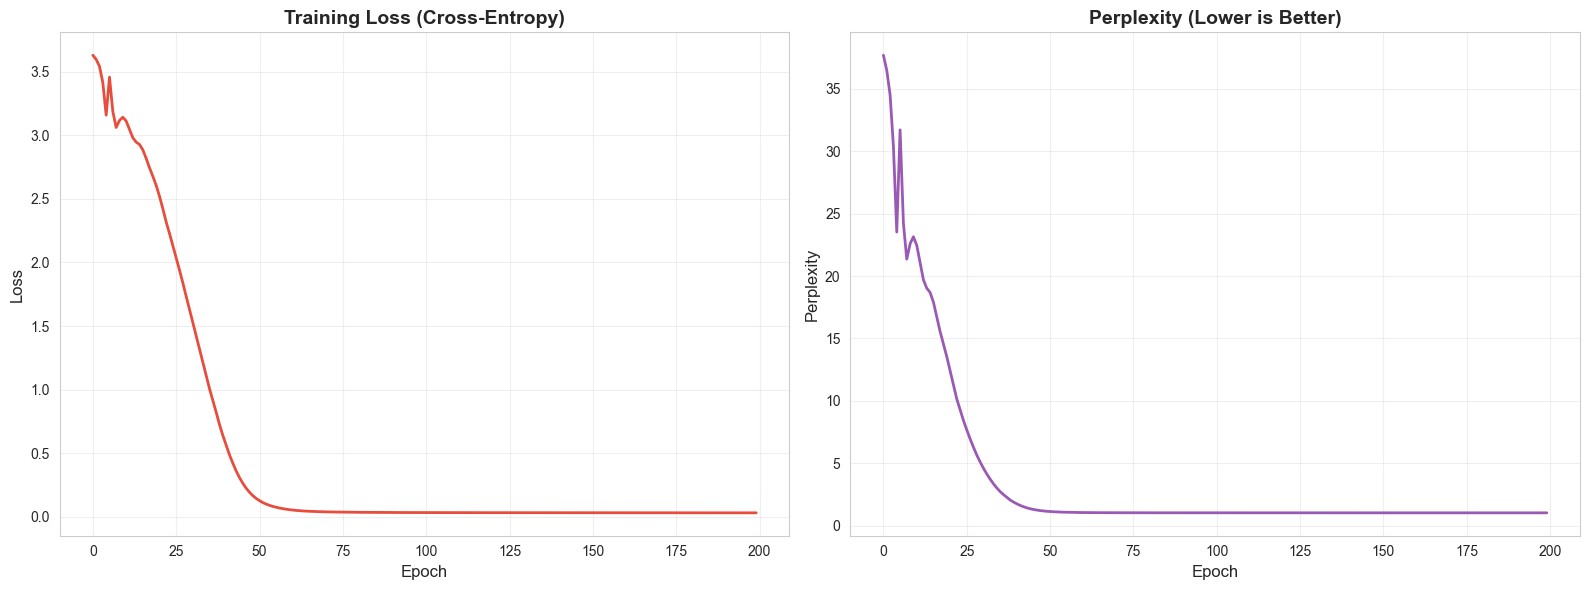


📊 Final Training Metrics:
   Loss: 0.0313
   Perplexity: 1.03

📈 Improvement:
   Loss reduced by: 99.1%
   Perplexity reduced by: 97.3%

💡 Interpretation:
   Perplexity < 10: Excellent! Model has strong predictive power.


In [10]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Loss curve
ax1.plot(history['loss'], linewidth=2, color='#e74c3c')
ax1.set_title('Training Loss (Cross-Entropy)', fontsize=14, fontweight='bold')
ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('Loss', fontsize=12)
ax1.grid(alpha=0.3)

# Perplexity curve
ax2.plot(history['perplexity'], linewidth=2, color='#9b59b6')
ax2.set_title('Perplexity (Lower is Better)', fontsize=14, fontweight='bold')
ax2.set_xlabel('Epoch', fontsize=12)
ax2.set_ylabel('Perplexity', fontsize=12)
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n📊 Final Training Metrics:")
print(f"   Loss: {history['loss'][-1]:.4f}")
print(f"   Perplexity: {history['perplexity'][-1]:.2f}")
print(f"\n📈 Improvement:")
print(f"   Loss reduced by: {(1 - history['loss'][-1]/history['loss'][0])*100:.1f}%")
print(f"   Perplexity reduced by: {(1 - history['perplexity'][-1]/history['perplexity'][0])*100:.1f}%")
print(f"\n💡 Interpretation:")
if history['perplexity'][-1] < 10:
    print(f"   Perplexity < 10: Excellent! Model has strong predictive power.")
elif history['perplexity'][-1] < 20:
    print(f"   Perplexity < 20: Good! Model makes reasonable predictions.")
else:
    print(f"   Perplexity > 20: Model is still uncertain. More training may help.")

## 🎨 Step 6: Text Generation

Now the fun part - let's generate some text!

In [11]:
# Generate text samples
seed_texts = [
    "The ",
    "In t",
    "Arti",
    "Once"
]

print("✨ Generating Text Samples\n")
print("=" * 70)

for seed in seed_texts:
    generated = generate_text(model, seed, char_to_idx, idx_to_char, length=100, temperature=1.0)
    print(f"\n🌱 Seed: '{seed}'")
    print(f"📝 Generated: {generated}")
    print("-" * 70)

✨ Generating Text Samples


🌱 Seed: 'The '
📝 Generated: The for forkss unpres unife maly.
ML acelprtcemor achine lazn.
MX ife machincelay docestuntilicon ramini
----------------------------------------------------------------------

🌱 Seed: 'In t'
📝 Generated: In tilicon ML acelerstanguie lazng.
Machincellign Apple'sing iep learn fox jump larngg hepls Shiling ise
----------------------------------------------------------------------

🌱 Seed: 'Arti'
📝 Generated: Articocp.sess Apples nemroteswunde.
Dep learn fox domes unifeificale.
Dep learning uses neralengi
se mor
----------------------------------------------------------------------

🌱 Seed: 'Once'
📝 Generated: Oncerorn forks wnh mon julps comurtachin learn nemaling ors awhin con provine laang.
Maciil antiol san u
----------------------------------------------------------------------

🌱 Seed: 'In t'
📝 Generated: In tilicon ML acelerstanguie lazng.
Machincellign Apple'sing iep learn fox jump larngg hepls Shiling ise
-------------------

### 🌡️ Temperature Exploration

**Temperature** controls creativity:
- **Low (0.5)**: Conservative, predictable text
- **Medium (1.0)**: Balanced creativity
- **High (1.5)**: Creative, surprising text

In [12]:
# Compare different temperatures
seed = "The "
temperatures = [0.5, 1.0, 1.5, 2.0]

print("🌡️ Temperature Comparison\n")
print("=" * 70)

generations = []
for temp in temperatures:
    generated = generate_text(model, seed, char_to_idx, idx_to_char, length=80, temperature=temp)
    generations.append(generated)
    
    print(f"\n🌡️ Temperature: {temp}")
    print(f"📝 {generated}")
    print("-" * 70)

print("\n💡 Observations:")
print("   - Lower temp: More repetitive, safer word choices")
print("   - Higher temp: More creative, sometimes nonsensical")
print("   - Sweet spot is usually between 0.7-1.2")

🌡️ Temperature Comparison


🌡️ Temperature: 0.5
📝 The laye.
Dep learn neure for arcitel ratificox jumpses nifid mamileang ile ple Sili
----------------------------------------------------------------------

🌡️ Temperature: 1.0
📝 The laye
ith langugeps ovi al any huan pule provdessg.
Machincelerttemor ML acerthew
----------------------------------------------------------------------

🌡️ Temperature: 1.5
📝 The julebsp ith lpali.
apl lang iutterluandiguase arciter ovceers ndhuges.
Maching u
----------------------------------------------------------------------

🌡️ Temperature: 2.0
📝 The pon MforXd.gMLX is  mpNo y
Macine lhawn htualeSacile layy hdemsond.
MLXc XmorsMs
----------------------------------------------------------------------

💡 Observations:
   - Lower temp: More repetitive, safer word choices
   - Higher temp: More creative, sometimes nonsensical
   - Sweet spot is usually between 0.7-1.2


### 📊 Visualize Temperature Effects

See how temperature affects the probability distribution.

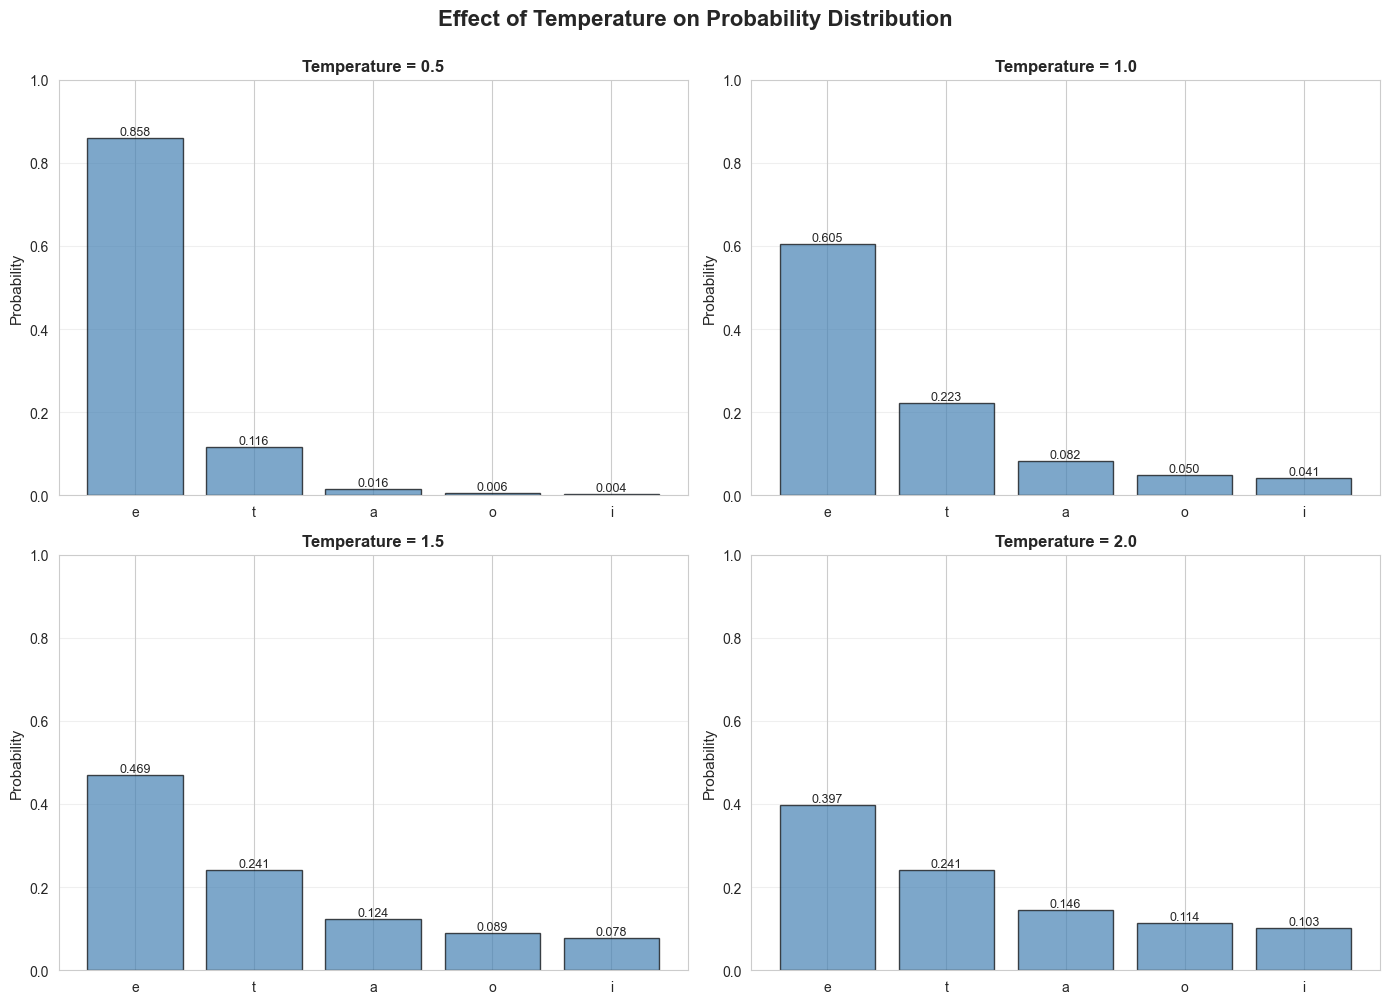


💡 Temperature Effects:
   - Low temp (0.5): Sharp distribution, picks 'e' almost always
   - Medium temp (1.0): Balanced, all characters have fair chance
   - High temp (2.0): Flat distribution, more random choices


In [13]:
# Simulate probability distribution with different temperatures
import mlx.core as mx

# Create sample logits (higher values = more likely)
sample_logits = mx.array([3.0, 2.0, 1.0, 0.5, 0.3])
char_labels = ['e', 't', 'a', 'o', 'i']  # Common characters

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
temps = [0.5, 1.0, 1.5, 2.0]

for idx, (ax, temp) in enumerate(zip(axes.flat, temps)):
    # Apply temperature and softmax
    scaled_logits = sample_logits / temp
    probs = mx.softmax(scaled_logits)
    probs_np = np.array(probs)
    
    # Plot
    bars = ax.bar(char_labels, probs_np, color='steelblue', edgecolor='black', alpha=0.7)
    ax.set_title(f'Temperature = {temp}', fontsize=12, fontweight='bold')
    ax.set_ylabel('Probability', fontsize=11)
    ax.set_ylim([0, 1])
    ax.grid(axis='y', alpha=0.3)
    
    # Add value labels
    for bar, prob in zip(bars, probs_np):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
               f'{prob:.3f}',
               ha='center', va='bottom', fontsize=9)

plt.suptitle('Effect of Temperature on Probability Distribution', 
            fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

print("\n💡 Temperature Effects:")
print("   - Low temp (0.5): Sharp distribution, picks 'e' almost always")
print("   - Medium temp (1.0): Balanced, all characters have fair chance")
print("   - High temp (2.0): Flat distribution, more random choices")

## 🧪 Step 7: Interactive Generation

Try your own seed text and parameters!

In [14]:
# YOUR CUSTOM PARAMETERS
custom_seed = "Once"  # Change this!
custom_length = 150  # How many characters to generate
custom_temp = 1.0  # Creativity level (0.5-2.0)

# Generate
result = generate_text(model, custom_seed, char_to_idx, idx_to_char, 
                      length=custom_length, temperature=custom_temp)

print(f"\n🌱 Seed: '{custom_seed}'")
print(f"🌡️ Temperature: {custom_temp}")
print(f"📏 Length: {custom_length} characters\n")
print(f"📝 Generated Text:")
print(f"{result}")
print(f"\n📊 Statistics:")
print(f"   Total length: {len(result)} characters")
print(f"   Word count: ~{len(result.split())} words")
print(f"   Unique characters: {len(set(result))}")


🌱 Seed: 'Once'
🌡️ Temperature: 1.0
📏 Length: 150 characters

📝 Generated Text:
Oncelprses numaleng il anguge.
Dep learning ile nhilg anersicne procestundesunge.
Naurniches neratelrang heps ovi ol artificaneige utife machincelerstandi

📊 Statistics:
   Total length: 154 characters
   Word count: ~18 words
   Unique characters: 24


### 📊 N-gram Analysis

Analyze patterns in generated text.

/var/folders/ps/xtrnb8ts7q576lcxkm4bgnhw0000gn/T/ipykernel_33358/2509689037.py:38: UserWarning: Glyph 8629 (\N{DOWNWARDS ARROW WITH CORNER LEFTWARDS}) missing from font(s) Arial.
  plt.tight_layout()
/Users/mark/git/apple-mlx-tutorial/.venv/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8629 (\N{DOWNWARDS ARROW WITH CORNER LEFTWARDS}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


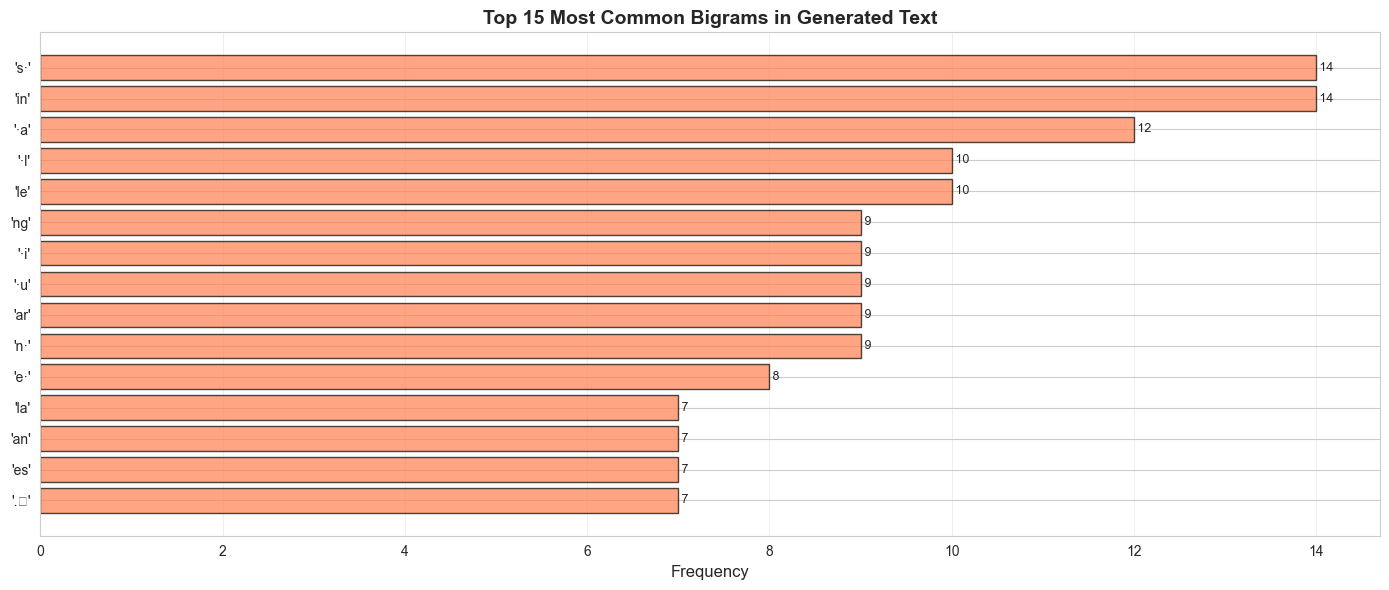


📊 N-gram Statistics:
   Total bigrams: 503
   Unique bigrams: 168
   Most common: 's ' (14 times)


In [15]:
# Generate longer sample for analysis
long_sample = generate_text(model, "The ", char_to_idx, idx_to_char, length=500, temperature=1.0)

# Count bigrams (2-character sequences)
bigrams = defaultdict(int)
for i in range(len(long_sample) - 1):
    bigram = long_sample[i:i+2]
    bigrams[bigram] += 1

# Get top 15 bigrams
top_bigrams = sorted(bigrams.items(), key=lambda x: x[1], reverse=True)[:15]
bigram_chars, bigram_counts = zip(*top_bigrams)

# Clean up for display
bigram_labels = []
for bg in bigram_chars:
    display = bg.replace(' ', '·').replace('\n', '↵')
    bigram_labels.append(f"'{display}'")

# Plot
fig, ax = plt.subplots(figsize=(14, 6))

bars = ax.barh(range(len(bigram_labels)), bigram_counts, color='coral', edgecolor='black', alpha=0.7)
ax.set_yticks(range(len(bigram_labels)))
ax.set_yticklabels(bigram_labels, fontsize=10)
ax.set_title('Top 15 Most Common Bigrams in Generated Text', fontsize=14, fontweight='bold')
ax.set_xlabel('Frequency', fontsize=12)
ax.invert_yaxis()
ax.grid(axis='x', alpha=0.3)

# Add value labels
for bar, count in zip(bars, bigram_counts):
    width = bar.get_width()
    ax.text(width, bar.get_y() + bar.get_height()/2.,
           f' {count}',
           ha='left', va='center', fontsize=9)

plt.tight_layout()
plt.show()

print(f"\n📊 N-gram Statistics:")
print(f"   Total bigrams: {sum(bigrams.values()):,}")
print(f"   Unique bigrams: {len(bigrams):,}")
print(f"   Most common: '{bigram_chars[0]}' ({bigram_counts[0]} times)")

## 🚀 Step 8: Training on Real Data (WikiText)

Ready for a serious text generator? Train on 36K Wikipedia articles!

In [16]:
print("📚 Training on WikiText Dataset (36K+ articles)\n")
print("=" * 70)
print("\n1️⃣  Download the dataset:")
print("   python ../scripts/download_datasets.py --text-generation")
print("\n2️⃣  Use the Complete Pipeline notebook:")
print("   Open '04_Complete_Pipeline.ipynb' to see how to train on full datasets.")
print("\n3️⃣  Expected performance:")
print("   - Training time: 30-40 minutes")
print("   - Final perplexity: ~15-20")
print("   - Vocabulary size: ~267 characters")
print("   - Training sequences: 2M+ sequences")
print("\n📊 Comparison:")
print("   Sample corpus: ~5,000 characters")
print("   WikiText: ~100M tokens")
print("\n✨ Results:")
print("   - More coherent text")
print("   - Better grammar and syntax")
print("   - Richer vocabulary")
print("   - Longer consistent passages")

📚 Training on WikiText Dataset (36K+ articles)


1️⃣  Download the dataset:
   python ../scripts/download_datasets.py --text-generation

2️⃣  Use the Complete Pipeline notebook:
   Open '04_Complete_Pipeline.ipynb' to see how to train on full datasets.

3️⃣  Expected performance:
   - Training time: 30-40 minutes
   - Final perplexity: ~15-20
   - Vocabulary size: ~267 characters
   - Training sequences: 2M+ sequences

📊 Comparison:
   Sample corpus: ~5,000 characters
   WikiText: ~100M tokens

✨ Results:
   - More coherent text
   - Better grammar and syntax
   - Richer vocabulary
   - Longer consistent passages


## 📝 Summary and Next Steps

### What You Learned

✅ **Language modeling** - Predicting next character/word  
✅ **Perplexity** - Measuring model uncertainty  
✅ **Temperature sampling** - Controlling creativity  
✅ **Text generation** - Creating human-like text  
✅ **N-gram analysis** - Understanding patterns  

### Key Takeaways

1. **Language modeling is hard** - Much harder than classification
2. **Perplexity = exp(loss)** - Intuitive measure of prediction quality
3. **Temperature controls randomness** - Balance between boring and nonsensical
4. **More data = better results** - WikiText vastly outperforms small corpus
5. **Character-level models** - Simple but effective for short sequences

### Practice Exercises

**🟢 Beginner:**
1. Try different seed texts and observe output quality
2. Experiment with temperatures from 0.3 to 2.5
3. Generate text of different lengths (10, 50, 200 characters)

**🟡 Intermediate:**
1. Modify sequence length (try 3, 10, 20) and observe effects
2. Train for more epochs (300, 500) and track perplexity
3. Implement word-level instead of character-level generation
4. Add beam search instead of greedy/sampling

**🔴 Advanced:**
1. Implement bidirectional LSTM for better context
2. Add attention mechanism to focus on relevant parts
3. Try different architectures (GRU, Transformer)
4. Implement top-k and nucleus (top-p) sampling
5. Fine-tune on specific domain (poetry, code, scientific text)
6. Build a chatbot using this generator + intent/sentiment models

### Next Notebook

Continue to **[04_Complete_Pipeline.ipynb](04_Complete_Pipeline.ipynb)** to learn:
- Combining all three techniques
- Building a complete chatbot
- Multi-model inference pipeline
- Production deployment strategies

---

**Congratulations! You can now build AI that writes text! 🎉**

## ❓ FAQ

**Q: Why is the generated text sometimes gibberish?**
A: Our model is relatively small and trained on a tiny dataset. Modern LLMs (like GPT-4) are trained on *trillions* of tokens. The "magic" of coherence emerges at scale.

**Q: What exactly is "Temperature"?**
A: Temperature scales the logits before the softmax.
*   **High Temp (>1.0):** Flattens the distribution. Rare words become more likely. (Creative/Chaotic)
*   **Low Temp (<1.0):** Sharpens the distribution. The most likely word becomes almost certain. (Focused/Repetitive)

**Q: How do I make the output deterministic?**
A: Set `temperature = 0` (or very close to 0) or use `argmax` instead of sampling. This will always pick the most likely next character.

## 💭 Closing Thoughts

**The Vanishing Gradient Problem**
We used an LSTM here because standard RNNs cannot remember long sequences. However, even LSTMs struggle with context longer than a few hundred tokens.

**Architectural Shift:**
This limitation is exactly why **Transformers** (which we cover in Notebook 05 & 06) took over. Transformers can "attend" to any part of the sequence instantly, regardless of distance, solving the long-term memory problem.